# Scam Prediction in Reddit

Done by : Zineb Bouharra, Rémi Hurstel, Ivo Bonetti, Ihssane Ghalas, Chaimaa Akharaze, Maroua El-Arni

### Problem Statement 

Online scams are a persistent problem on social media platforms, and Reddit is no exception. Scammers often use manipulative tactics to deceive unsuspecting users into participating in fraudulent schemes, which can result in significant financial loss and other negative consequences. Detecting these scams is a challenging task, as scammers use subtle language and psychological techniques to evade detection. Moreover, the vast and diverse nature of Reddit's user-generated content makes it difficult to identify and analyze all potential scam posts and comments manually. As a result, there is a pressing need for an effective scam prediction model for Reddit that can accurately detect and alert users to potential scams.


To address this problem, researchers and developers have been exploring various approaches to predict scams on Reddit. Some of the proposed techniques include using machine learning algorithms, natural language processing, and network analysis to identify patterns and anomalies in Reddit's user-generated content. These approaches aim to develop models that can automatically distinguish between legitimate and fraudulent posts and comments. By leveraging the vast amounts of data available on Reddit, these models can learn to detect subtle cues and characteristics that indicate scam-like behavior.


Therefore, the challenge is to develop an effective scam prediction model for Reddit that can accurately identify and alert users to potential scam posts and comments, ultimately reducing the risk of financial harm and improving the overall safety and trustworthiness of the platform.

### Necessary imports

In [1]:
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import numpy as np

In [3]:
import warnings
warnings.filterwarnings('ignore')

### Loading the dataset

The original data contains 147843 examples that we split into train and test datasets as follows :

- The training dataset contains 67% of the original dataset. It is accessible in CSV format in data/train.csv

- The testing dataset contains 33% of the original dataset. It is accessible in CSV format in data/test.csv

In [4]:
data_train = pd.read_csv('data/train.csv')
data_test = pd.read_csv('data/test.csv')


### Data Insights

In [5]:
data_train.head()

,name,comment_karma,link_karma,type,body,subreddit,label
0,good_or_bread,1904,91,submission,I'm Swiss AMA : Bonus point if it isn't a joke...,AMA,0
1,pdrooyeah,281,585,comment,"it was also very triggering, because ""I don't ...",manga,0
2,Le_Faveau,15363,9839,comment,Late reply but the Sellsword Twinblades are th...,Eldenring,0
3,erer566,1987,12218,submission,Bitcoin investing interest up 19% compared to ...,CryptoCurrency,1
4,dah020,1708,1310,comment,And some people argue that the world is flat. ...,unpopularopinion,1


In [6]:
data_train.shape

(99054, 7)

In [7]:
data_test.head()

,name,comment_karma,link_karma,type,body,subreddit,label
0,fite_me_bitch,22008,1,comment,"Apparently so, because that's what this is.",TwoXChromosomes,1
1,lukasr92,88,11,comment,It seems that I don’t get a code for redemptio...,Dashlane,1
2,lilyysreddit,1162,1150,comment,she counted for a while when she crawled,LoveIslandTV,0
3,anahitareddit,4751,634,submission,I may have made this for personal reasons but ...,memes,0
4,lightshayde,2518,575,submission,Thinking about PMO after being free of use for...,NoFap,1


In [8]:
data_test.shape

(48789, 7)

In [9]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99054 entries, 0 to 99053
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   name           99054 non-null  object
 1   comment_karma  99054 non-null  int64 
 2   link_karma     99054 non-null  int64 
 3   type           99054 non-null  object
 4   body           99054 non-null  object
 5   subreddit      99054 non-null  object
 6   label          99054 non-null  int64 
dtypes: int64(3), object(4)
memory usage: 5.3+ MB


In [10]:
data_train.describe()

,comment_karma,link_karma,label
count,9.905400e+04,9.905400e+04,99054.000000
mean,1.084470e+04,6.993638e+03,0.303875
std,5.342152e+04,7.614162e+04,0.459931
min,-1.000000e+02,1.000000e+00,0.000000
25%,3.570000e+02,1.000000e+02,0.000000
50%,1.994000e+03,8.900000e+02,0.000000
75%,8.181750e+03,4.408000e+03,1.000000
max,3.141592e+06,4.841046e+06,1.000000


In [11]:
data_train.describe(include=object)

,name,type,body,subreddit
count,99054,99054,99054,99054
unique,9077,2,96208,14653
top,beehale,comment,u/savevideo,AskReddit
freq,20,55996,81,2620


As we can see our dataset contains basically two types of data, some columns are int while the others are object.

In the following part we will do some data exploration to understand more the data.

### Data Exploration

We first check if there are any missing values in the dataset

In [12]:
data_train.isna().sum()

name             0
comment_karma    0
link_karma       0
type             0
body             0
subreddit        0
label            0
dtype: int64

In [13]:
data_train = data_train.dropna(axis=0)

In [14]:
data_test.isna().sum()

name             0
comment_karma    0
link_karma       0
type             0
body             1
subreddit        0
label            0
dtype: int64

In [15]:
data_test = data_test.dropna(axis=0)

Here, we plot the counts of comments and submissions.

comment       55996
submission    43058
Name: type, dtype: int64


<AxesSubplot: >

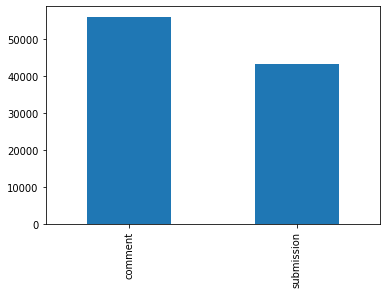

In [16]:
print(data_train.type.value_counts())
data_train.type.value_counts().plot(kind='bar')

And then we plot the count of each label (0,1).

0    68954
1    30100
Name: label, dtype: int64


<AxesSubplot: >

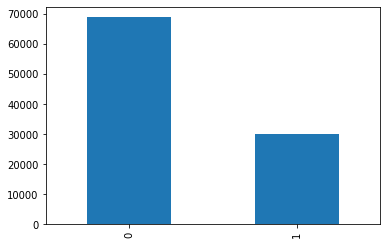

In [17]:
print(data_train.label.value_counts())
data_train.label.value_counts().plot(kind='bar')

Let's plot the distribution of the variable type when it comes to our target.

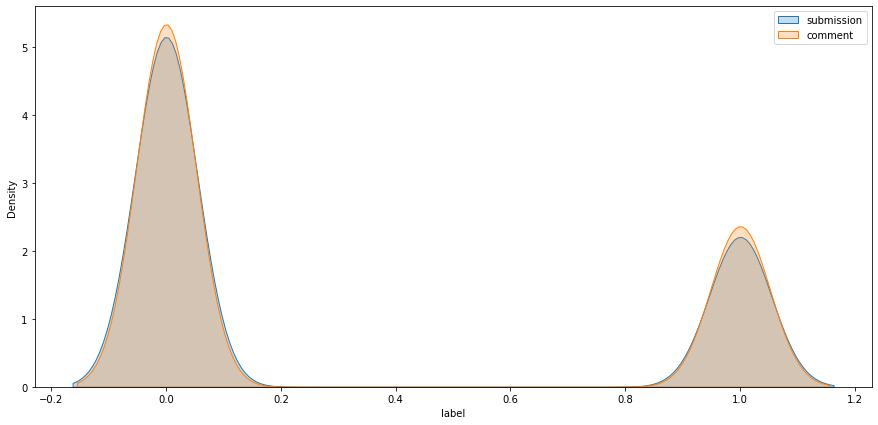

In [23]:
vals = list(data_train['type'].unique())
plt.figure(figsize=(15,7))
for val in vals:
    sns.kdeplot(data_train[data_train['type']==val]['label'],label=val,shade=True)
plt.legend()

Let's now plot the correlation between the numerical features

<AxesSubplot: >

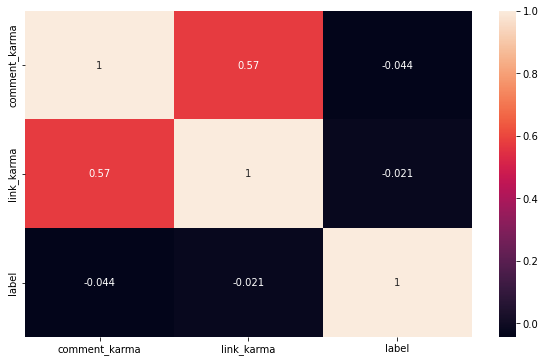

In [19]:
plt.figure(figsize=(10,6))
sns.heatmap(data_train.corr(method='pearson'),annot=True)

We can plot a pair plot. This will show us how numerical feature's points are distributed in relation to other features.

[]

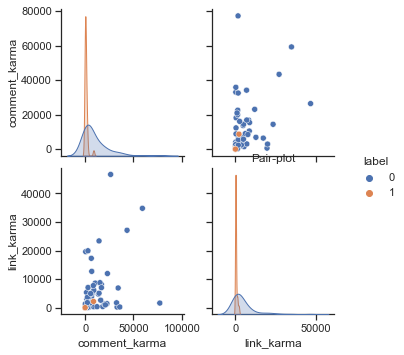

In [109]:

sns.set_theme(style='ticks')
sns.pairplot(data_train.iloc[:100], hue='label')
plt.title('Pair-plot')
plt.plot()

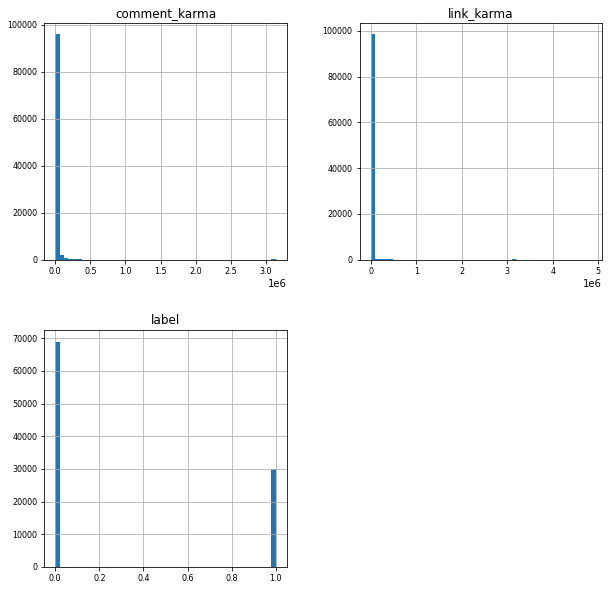

In [41]:
data_train.hist(figsize=(10, 10), bins = 50, xlabelsize=8, ylabelsize=8)
plt.show()